### Data representation

In [1]:
# Подключаем необходимые библиотеки
import nibabel as nib
import numpy as np

In [2]:
# Достаём 3D-изображение из .nii файла
img3d = nib.load("../Dataset/mts-1/FL/Ax Flair mts-1.nii")
type(img3d)

nibabel.nifti1.Nifti1Image

In [3]:
# Переводим изображение в numpy ndarray
img_data = img3d.get_fdata()
print(f"Object type after get_fdata(): {type(img_data)}")

img_data = np.asarray(img_data)

print(f"\nFinal data type is {type(img_data)} with a shape of (width, height, number of slices, [?]):\n{img_data.shape}")

Object type after get_fdata(): <class 'numpy.memmap'>

Final data type is <class 'numpy.ndarray'> with a shape of (width, height, number of slices, [?]):
(512, 512, 20, 1)


In [4]:
# Преобразуем пока к 3-х мерному массиву
# img_data = img_data.reshape(512, 512, -1)
print(f"Data shape: {img_data.shape}\n")
print(img_data)

Data shape: (512, 512, 20, 1)

[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[4.]
   [1.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[3.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[2.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[6.]
   [1.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[4.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[6.]
   [5.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[4.]
   [3.]
   [1.]
   ...
 

In [5]:
# Достанем картинку (1-ый срез) из полученного массива
from PIL import Image
# img_data_transpose = img_data.T
img = Image.fromarray(img_data[:, 256, :, 0], "L")
img.save("image_1sl.jpeg")

Полученное изображение имеет неудовлетворительный для работы вид  
*Покрутим ещё*
<!-- <img src="image_1sl.jpeg" align="left"> -->

In [6]:
# Попробуем лучше строить графики
import matplotlib.pyplot as plt

def show_slices(slices):
    nrows = len(slices) // 5
    fig, axes = plt.subplots(nrows, 5, figsize=(20,20))
    for i in range(nrows):
        for j, slice in enumerate(slices[i*5 : i*5 + 5]):
            axes[i][j].imshow(slice.T, cmap="gray", origin="lower")
#             axes[i][j].set_yticklabels([])
#             axes[i][j].set_xticklabels([])

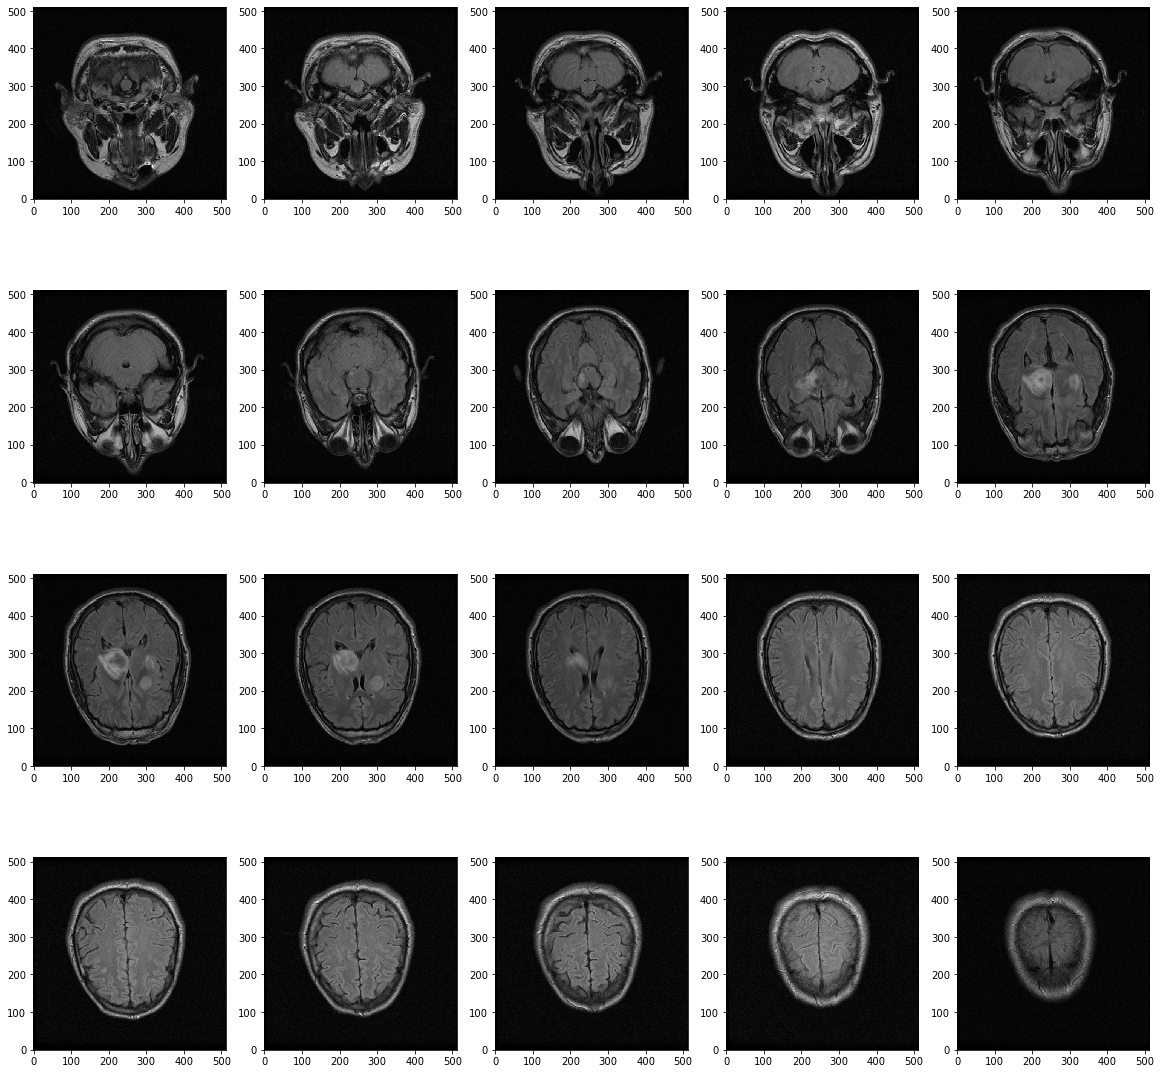

In [7]:
slices = []
for slice_index in range(img_data.shape[2]):
    slices.append(img_data[:, :, slice_index, 0])
show_slices(slices)

### Data preparing

In [8]:
import os.path
from os import listdir

In [9]:
def represent_data(nii_files):
    nii_objects = []
    for file in nii_files:
        print(file)
        nii_obj = nib.load(file)
        nii_obj = np.asarray(nii_obj.get_fdata())
        
        print(nii_obj.shape)
        if nii_obj.shape[:2] != (512, 512):
            pad_size1 = (512 - nii_obj.shape[0])//2
            pad_size2 = (512 - nii_obj.shape[1])//2
            nii_obj = np.pad(nii_obj, [(pad_size1,pad_size1), (pad_size2,pad_size2), (0,0), (0,0)], constant_values=(0,))
        
        if nii_obj.shape[2] < 20:
            nii_obj = np.concatenate((nii_obj[:,:,:nii_obj.shape[2]//2,:],
                                      nii_obj[:,:,nii_obj.shape[2]//2 : nii_obj.shape[2]//2 + 2,:],
                                      nii_obj[:,:,nii_obj.shape[2]//2:,:]), axis=2)
            
        print(nii_obj.shape)
        
        # Обрезаем данные как бы не было нам больно
        if(nii_obj.shape[2] > 20):
            if (nii_obj.shape[2] - 20) % 2 == 0:
                left = (nii_obj.shape[2] - 20) // 2
                right = left
            else:
                right = (nii_obj.shape[2] - 20) // 2 + 1
                left = right - 1
            nii_objects.append(nii_obj[:,:,left:-right,:])
        else:
            nii_objects.append(nii_obj)

    full_nii_data = np.concatenate(tuple(nii_objects), axis=3)
    print(f"Full nii data shape: {full_nii_data.shape}")

    full_nii_data_file = nib.Nifti1Image(full_nii_data, np.eye(4))

    # Проверка на тип хранимых данных
    # full_nii_data_file.get_data_dtype() == np.dtype(np.float64)

    # full_nii_data_file.header.get_xyzt_units()
    
    if "mts" in file:
        ind_start = file.find("mts")
        ind_fin = file.find("/", ind_start)
        folder_name = "mts"
        file_name = file[ind_start : ind_fin] + ".nii"
    if "norma" in file:
        ind_start = file.find("norma")
        ind_fin = file.find("/", ind_start)
        folder_name = "norma"
        file_name = file[ind_start : ind_fin] + ".nii"
    print(folder_name, file_name)
    
    nib.save(full_nii_data_file, os.path.join(folder_name, file_name))
    print("------------------------------------------------------")

In [10]:
# Для всех
start_path = "../Dataset"
count = 0
for folder in listdir(start_path):
    nii_files = []
    folder_path = start_path + "/" + folder
    # print(folder_path)
    if os.path.isdir(folder_path):
        
        for subfolder in listdir(folder_path):
            subfolder_path = folder_path + "/" + subfolder
            if os.path.isdir(subfolder_path):
                
                for file in listdir(subfolder_path):
                    file_path = subfolder_path + "/" + file
                    if file.endswith(".nii"):
                        nii_files.append(file_path)

        represent_data(nii_files)
        count+=1
        
print(f"Total: {count} patients data")

../Dataset/mts-1/FL/Ax Flair mts-1.nii
(512, 512, 20, 1)
(512, 512, 20, 1)
../Dataset/mts-1/T1/AX_T1_mts-1.nii
(256, 256, 20, 1)
(512, 512, 20, 1)
../Dataset/mts-1/T1+c/AX_T1_SE+C_mts-1.nii
(256, 256, 20, 1)
(512, 512, 20, 1)
Full nii data shape: (512, 512, 20, 3)
mts mts-1.nii
------------------------------------------------------
../Dataset/mts-10/FL/Ax T2 FLAIR mts-10.nii
(512, 512, 25, 1)
(512, 512, 25, 1)
../Dataset/mts-10/T1/Ax T1 FSE mts-10.nii
(256, 256, 24, 1)
(512, 512, 24, 1)
../Dataset/mts-10/T1+c/Ax T1 FSE+C mts-10.nii
(256, 256, 24, 1)
(512, 512, 24, 1)
Full nii data shape: (512, 512, 20, 3)
mts mts-10.nii
------------------------------------------------------
../Dataset/mts-11/Fl/ax fl mts-11.nii
(512, 512, 18, 1)
(512, 512, 20, 1)
../Dataset/mts-11/mts-11 dicom/Ax T1 FSE+C mts 11.nii
(256, 256, 18, 1)
(512, 512, 20, 1)
../Dataset/mts-11/T1+c/Ax T1 FSE+C mts 11.nii
(256, 256, 18, 1)
(512, 512, 20, 1)
Full nii data shape: (512, 512, 20, 3)
mts mts-11.nii
-----------------

------------------------------------------------------
../Dataset/mts-31/fl/Ax Flair mts-31.nii
(512, 512, 21, 1)
(512, 512, 21, 1)
../Dataset/mts-31/t1/Ax T1 SE mts-31.nii
(256, 256, 21, 1)
(512, 512, 21, 1)
../Dataset/mts-31/t1+c/Ax T1 SE c mts-31.nii
(256, 256, 21, 1)
(512, 512, 21, 1)
Full nii data shape: (512, 512, 20, 3)
mts mts-31.nii
------------------------------------------------------
../Dataset/mts-32/fl/Ax Flair mts-32.nii
(512, 512, 21, 1)
(512, 512, 21, 1)
../Dataset/mts-32/t1/Ax T1 mts-32.nii
(256, 256, 21, 1)
(512, 512, 21, 1)
../Dataset/mts-32/t1 c/Ax T1 SE+C mts-32.nii
(256, 256, 21, 1)
(512, 512, 21, 1)
Full nii data shape: (512, 512, 20, 3)
mts mts-32.nii
------------------------------------------------------
../Dataset/mts-33/fl/ax fl mts-33.nii
(336, 384, 27, 1)
(512, 512, 27, 1)
../Dataset/mts-33/t1/ax t1 mts-33.nii
(208, 256, 160, 1)
(512, 512, 160, 1)
../Dataset/mts-33/t1 c/ax t1 c mts-33.nii
(384, 448, 25, 1)
(512, 512, 25, 1)
Full nii data shape: (512, 512, 

Full nii data shape: (512, 512, 20, 3)
norma norma-2.nii
------------------------------------------------------
../Dataset/norma-3/fl/Ax Flair irFSE norma-3.nii
(512, 512, 22, 1)
(512, 512, 22, 1)
../Dataset/norma-3/t1/AX T1 SE norma-3.nii
(256, 256, 22, 1)
(512, 512, 22, 1)
../Dataset/norma-3/t1+c/AX T1 SE+C norma-3.nii
(256, 256, 22, 1)
(512, 512, 22, 1)
Full nii data shape: (512, 512, 20, 3)
norma norma-3.nii
------------------------------------------------------
../Dataset/norma-4/fl/Ax Flair irFSE norma-4.nii
(512, 512, 22, 1)
(512, 512, 22, 1)
../Dataset/norma-4/t1/AX T1 SE norma-4.nii
(256, 256, 22, 1)
(512, 512, 22, 1)
../Dataset/norma-4/t1+c/AX T1 SE+C norma-4.nii
(256, 256, 22, 1)
(512, 512, 22, 1)
Full nii data shape: (512, 512, 20, 3)
norma norma-4.nii
------------------------------------------------------
../Dataset/norma-5/fl/Ax Flair irFSE norma-5.nii
(512, 512, 23, 1)
(512, 512, 23, 1)
../Dataset/norma-5/t1/AX T1 SE norma-5.nii
(256, 256, 23, 1)
(512, 512, 23, 1)
../Dat

(512, 512, 20, 3)


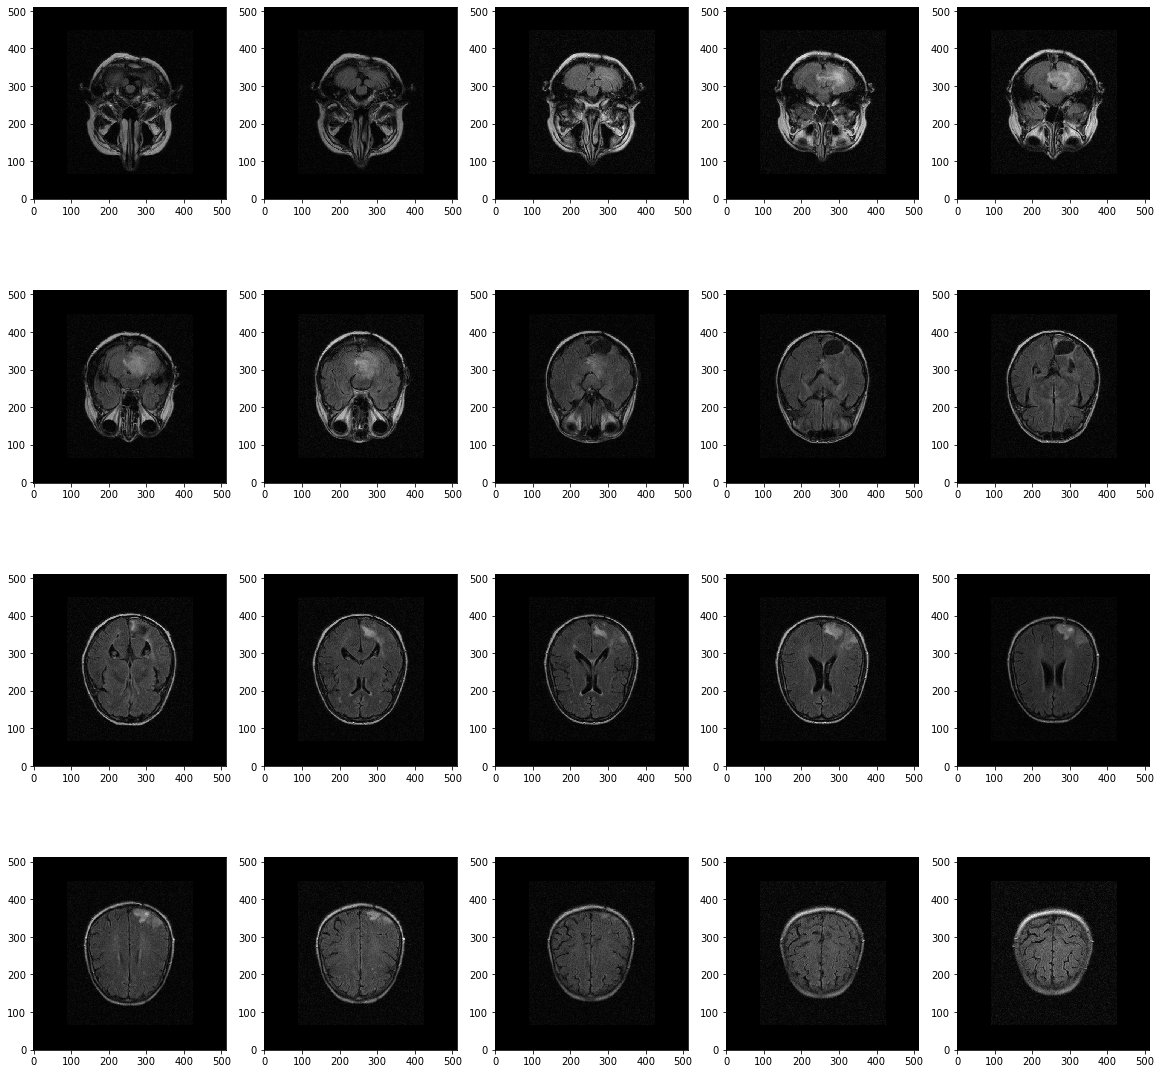

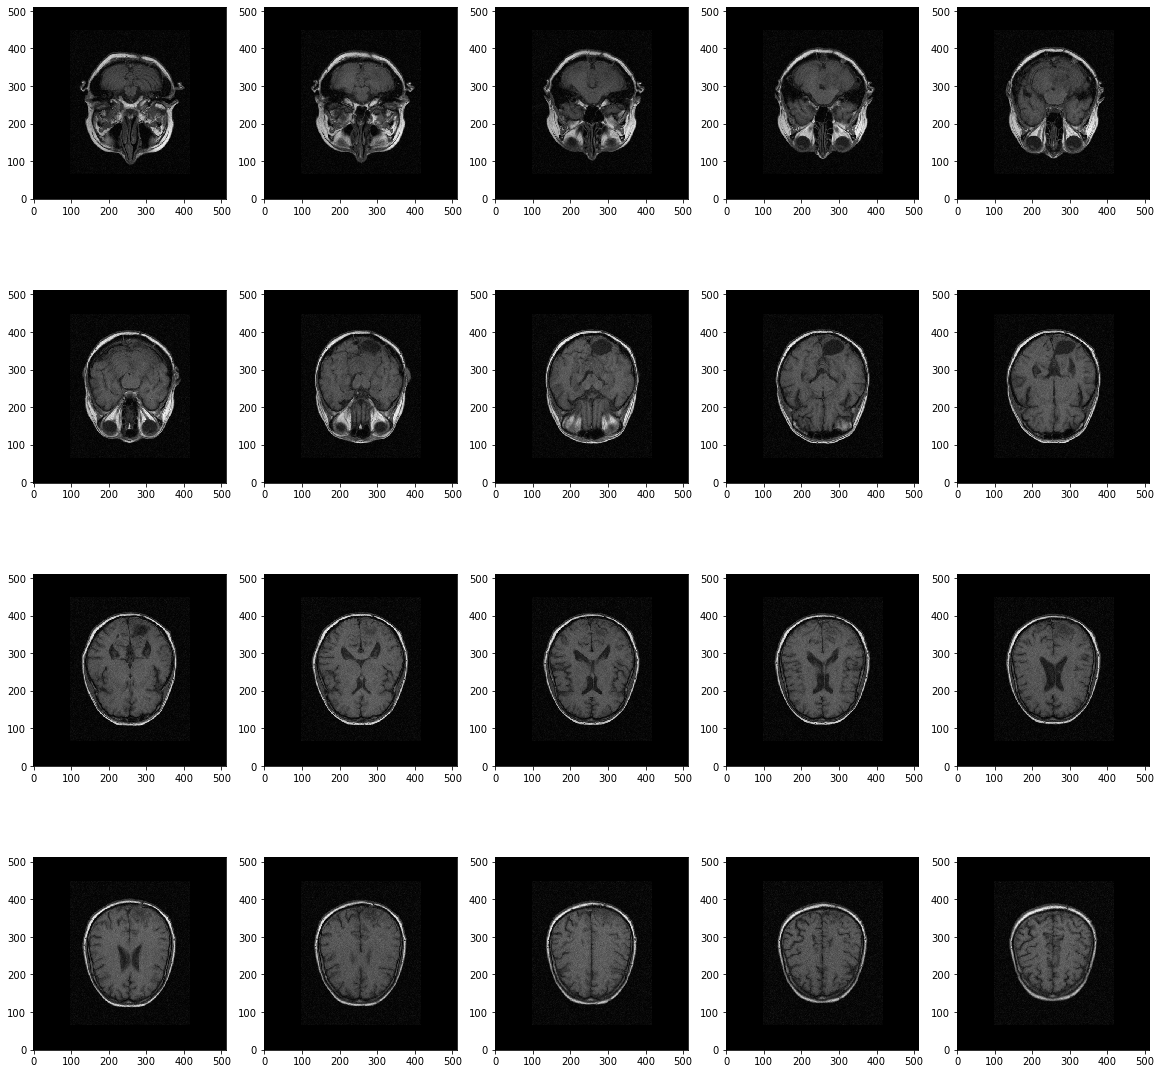

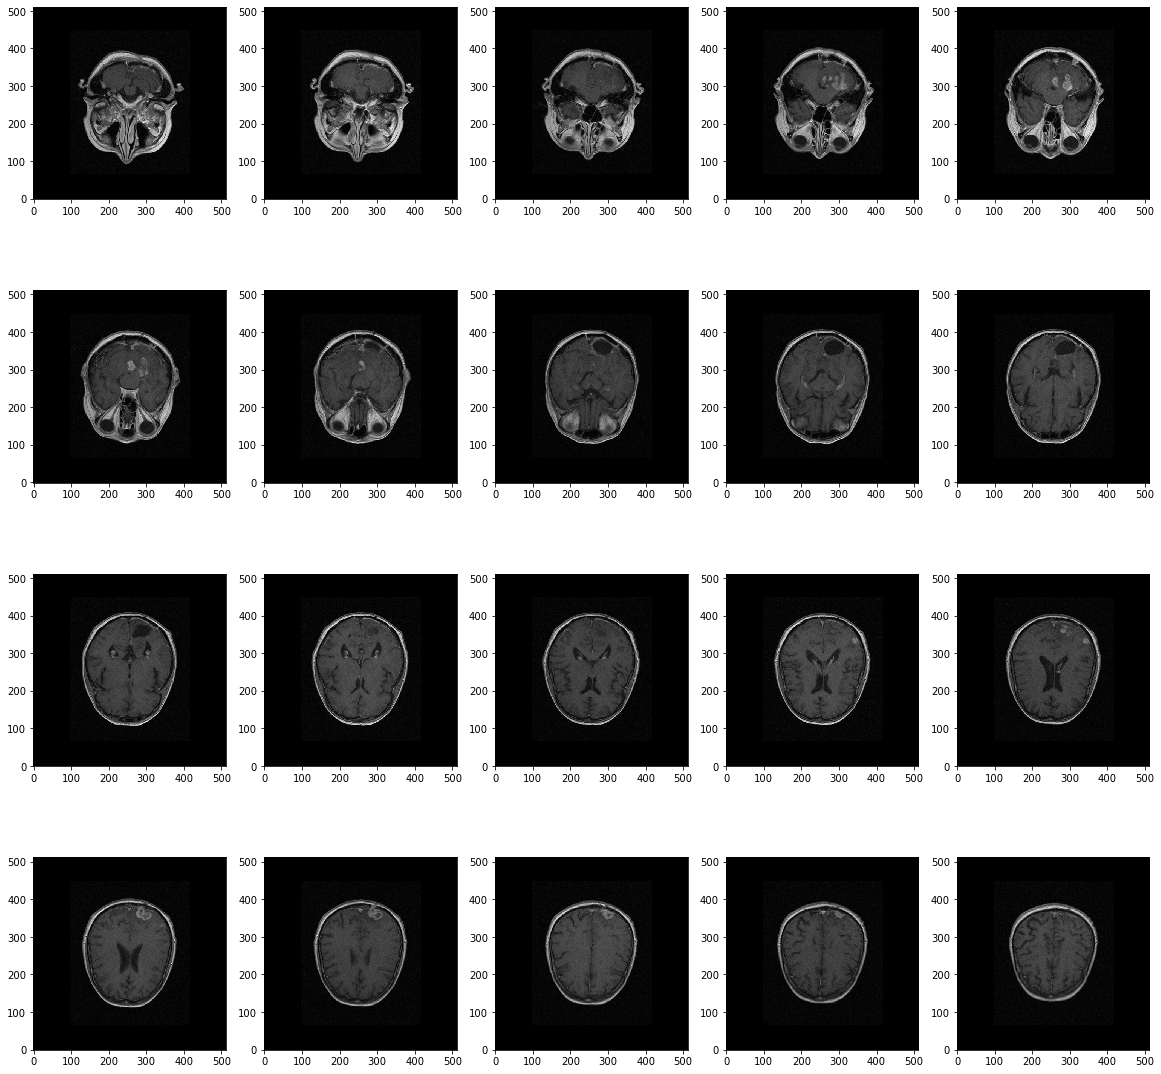

In [11]:
# Посмотрим на снимки, которые у нас есть по одному пациенту
p1_file = nib.load("mts/mts-8.nii")
p1 = np.asarray(p1_file.get_fdata())
print(p1.shape)
for i in range(p1.shape[3]):
    slices = []
    for slice_index in range(p1.shape[2]):
        slices.append(p1[:, :, slice_index, i])
    show_slices(slices)

(512, 512, 20, 3)


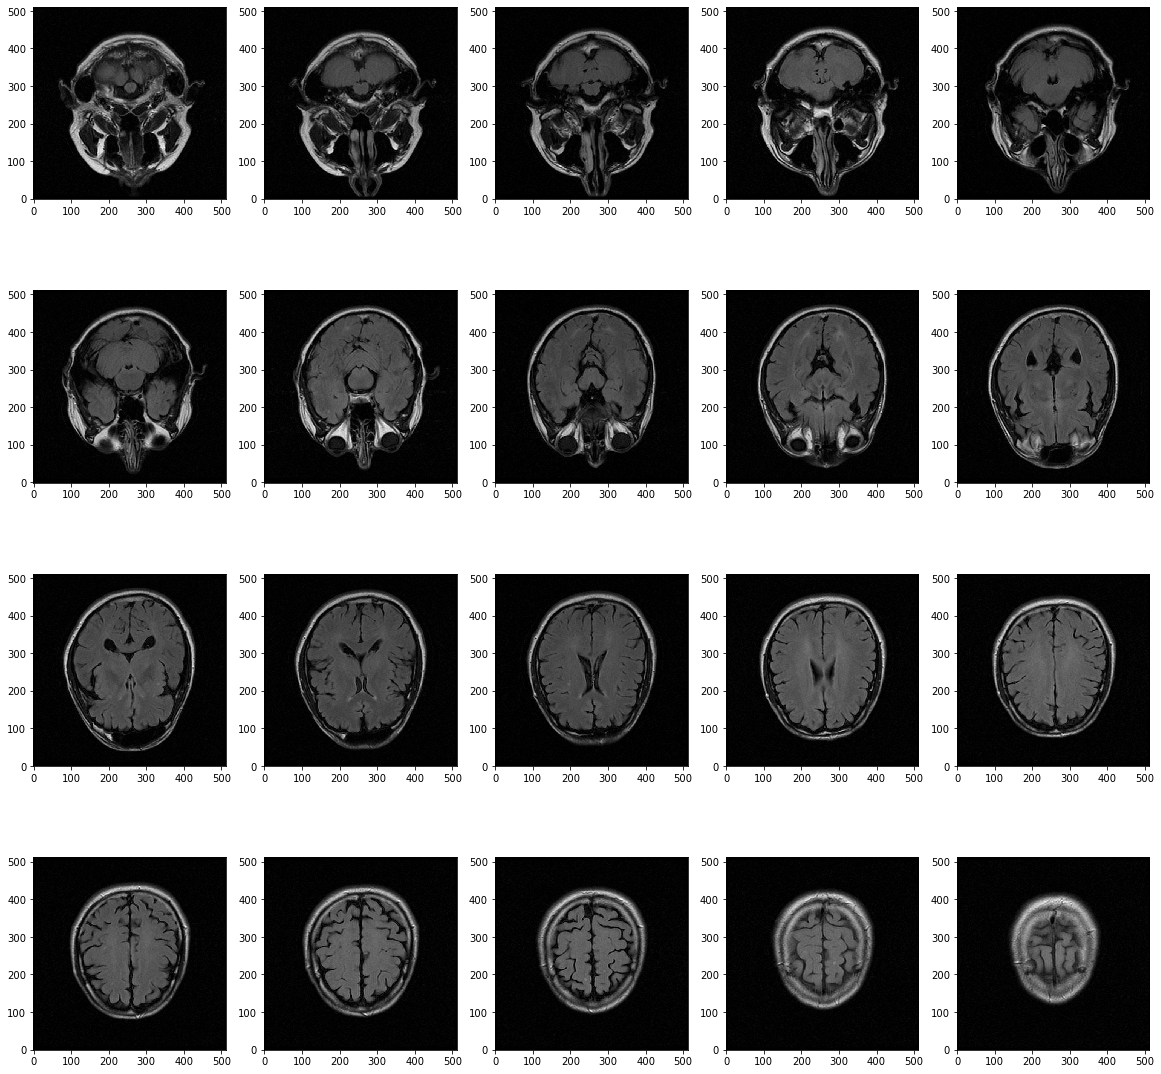

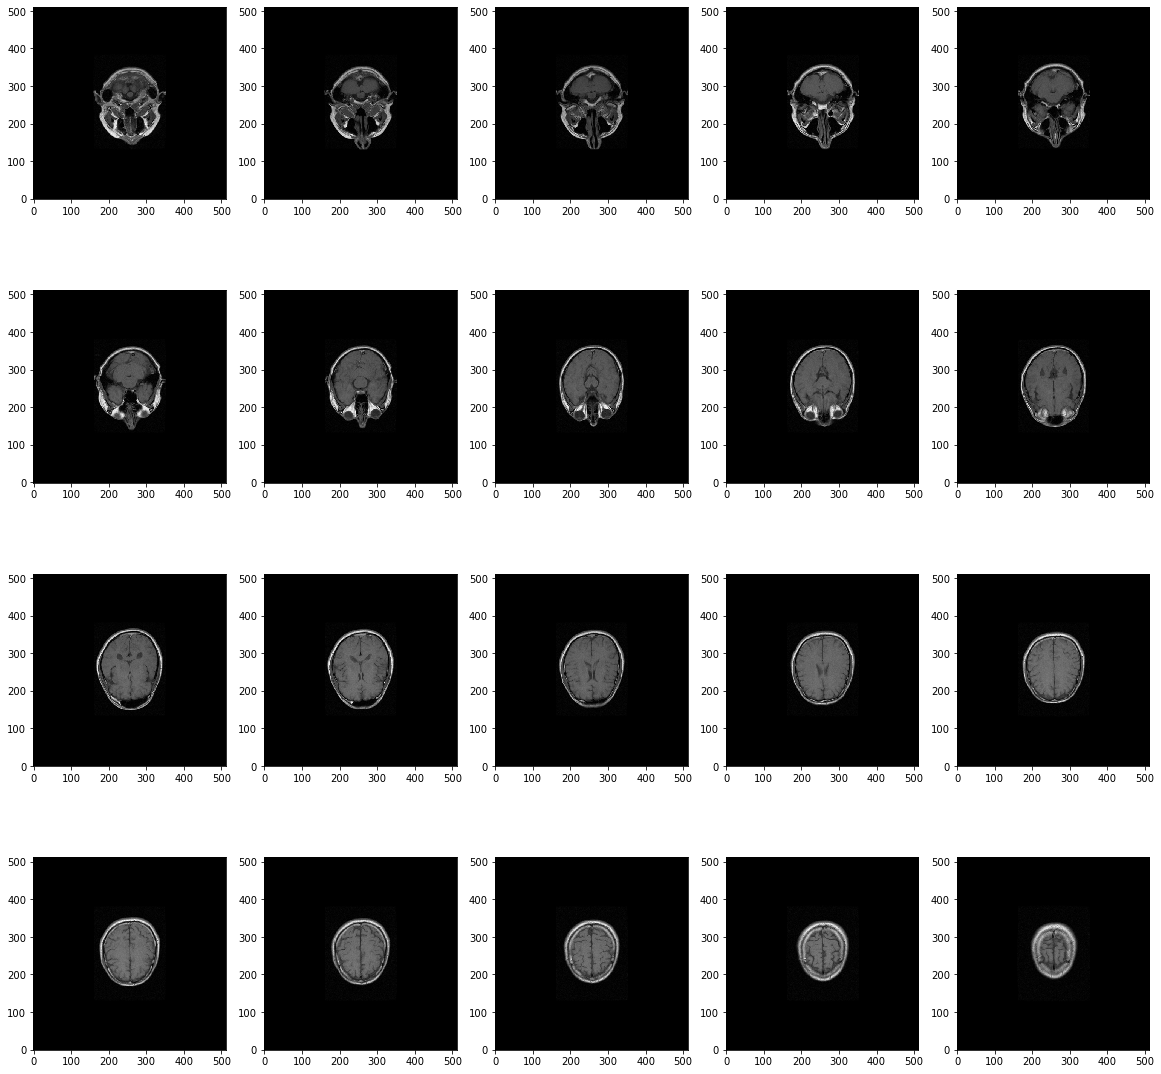

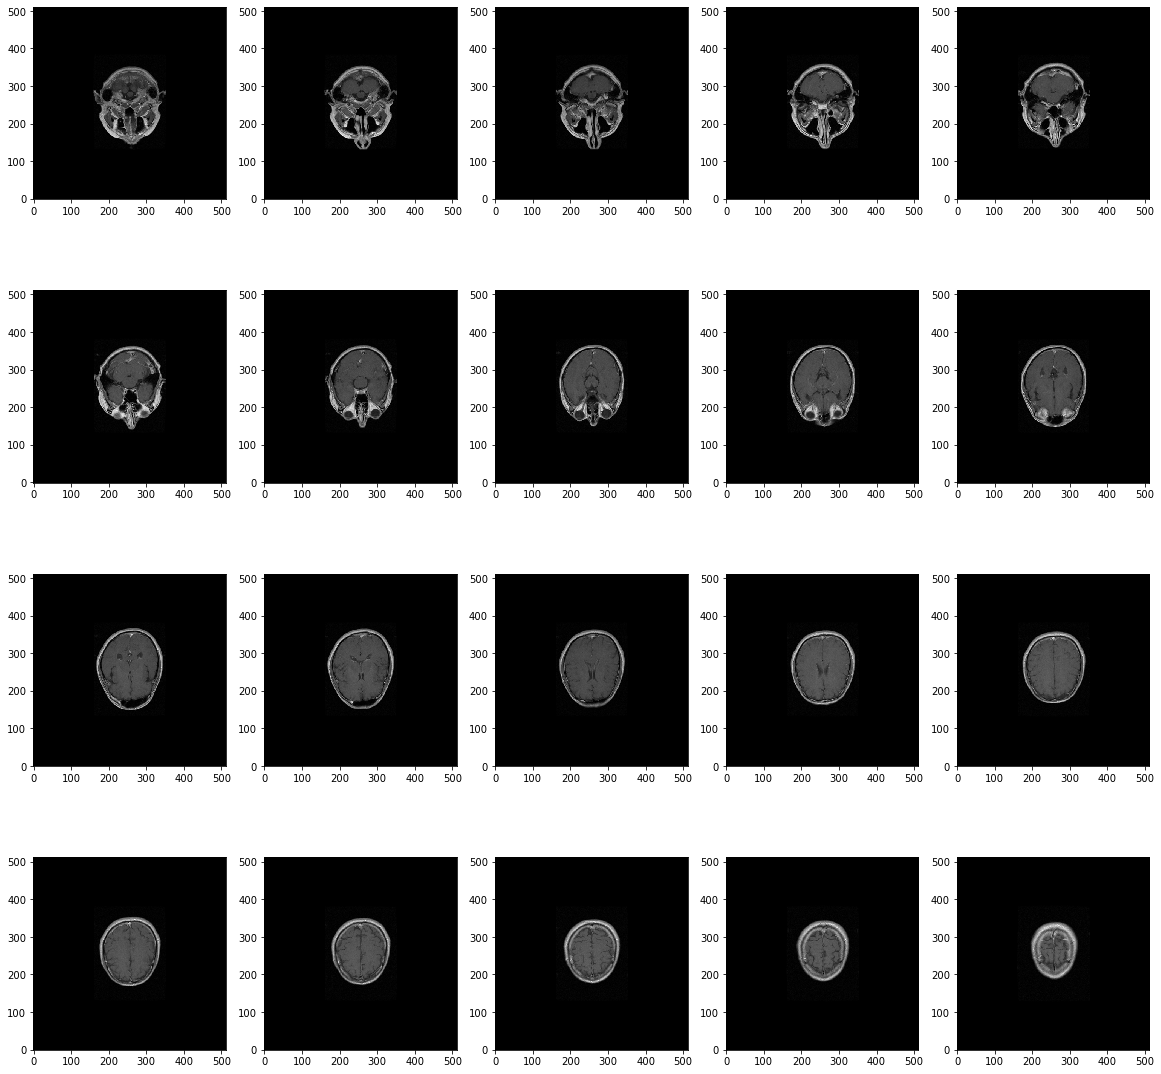

In [13]:
p2_file = nib.load("norma/norma-8.nii")
p2 = np.asarray(p2_file.get_fdata())
print(p2.shape)
for i in range(p2.shape[3]):
    slices = []
    for slice_index in range(p2.shape[2]):
        slices.append(p2[:, :, slice_index, i])
    show_slices(slices)

### That's all, folks!